## Import Libraries

In [147]:
import gymnasium as gym
import gym_puddle
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3.dqn import MlpPolicy as DQNPolicy
from stable_baselines3.ppo import MlpPolicy as PPOPolicy

import time
import json

import matplotlib.pyplot as plt
import numpy as np

from IPython import display
import pyvirtualdisplay
import cv2

import libs.tiles3 as tc


## Visualization Functions

In [148]:

#some functions to help the visualization and interaction wit the environment

def visualize(frames, video_name = "/results/video.mp4"):
    # Saves the frames as an mp4 video using cv2
    video_path = video_name
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    video_writer = cv2.VideoWriter(video_path, fourcc, 30, (width, height))
    for frame in frames:
        video_writer.write(frame)
    video_writer.release()

def online_rendering(image):
    #Visualize one frame of the image in a display
    ax.axis('off')
    img_with_frame = np.zeros((image.shape[0]+2, image.shape[1]+2, 3), dtype=np.uint8)
    img_with_frame[1:-1, 1:-1, :] = image
    ax.imshow(img_with_frame)
    display.display(plt.gcf())
    display.clear_output(wait=True)


def prepare_display():
  #Prepares display for onine rendering of the frames in the game
  _display = pyvirtualdisplay.Display(visible=False,size=(1400, 900))
  _ = _display.start()
  fig, ax = plt.subplots(figsize=(5, 5))
  ax.axis('off')


def get_action():
    action = None
    while action not in ["w", "a", "s", "d", "W", "A", "S", "D"]:
        action = input("Enter action (w/a/s/d): ")
    if action == "w":
        return 3
    elif action == "a":
        return 0
    elif action == "s":
        return 2
    elif action == "d":
        return 1

## Accessing Different Environment Configurations

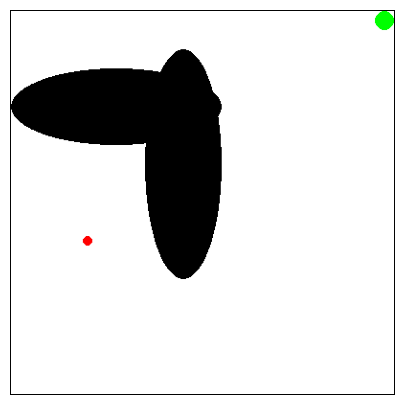

In [149]:
json_file = f"/Users/hadiaghazadeh/Library/CloudStorage/OneDrive-UniversityofCalgary/@upperboundCompetition/gym-puddle/gym_puddle/env_configs/pw1.json"

with open(json_file) as f:
  env_setup = json.load(f)

env = gym.make(
  "PuddleWorld-v0",
  start=env_setup["start"],
  goal=env_setup["goal"],
  goal_threshold=env_setup["goal_threshold"],
  noise=env_setup["noise"],
  thrust=env_setup["thrust"],
  puddle_top_left=env_setup["puddle_top_left"],
  puddle_width=env_setup["puddle_width"],
)

obs, info = env.reset()
image = env.render()
fig, ax = plt.subplots(figsize=(5, 5))

online_rendering(image)

## Environment Details

In [150]:
print("start position:", env.get_wrapper_attr("start"))
print("goal position:", env.get_wrapper_attr("goal"))
print("goal threshold:", env.get_wrapper_attr("goal_threshold"))
print("action noise:", env.get_wrapper_attr("noise"))
print("agent's thrust:", env.get_wrapper_attr("thrust"))
print("puddle top left positions:", env.get_wrapper_attr("puddle_top_left"))
print("puddle widths and heights:", env.get_wrapper_attr("puddle_width"))
print("action space:", env.get_wrapper_attr("actions"))
print("observation space:", env.get_wrapper_attr("observation_space"))

start position: [0.2 0.4]
goal position: [1. 1.]
goal threshold: 0.1
action noise: 0.01
agent's thrust: 0.05
puddle top left positions: [array([0.  , 0.85]), array([0.35, 0.9 ])]
puddle widths and heights: [array([0.55, 0.2 ]), array([0.2, 0.6])]
action space: [array([-0.05,  0.  ]), array([0.05, 0.  ]), array([ 0.  , -0.05]), array([0.  , 0.05])]
observation space: Box(0.0, 1.0, (2,), float64)


## Tile coding

In [165]:
import numpy as np

# Define the tile coding parameters
num_tilings = 5
num_tiles = 5
num_actions = len(env.get_wrapper_attr("actions"))
num_dimensions = len(env.get_wrapper_attr("start"))
observation_space = [0.0, 1.0]  # Assuming observation space is [0, 1] for both dimensions


# Create an index hash table
iht_size = 4096  # Should be a power of 2 # 4096
iht = tc.IHT(iht_size)

def tile_code(state):
    tiles = []
    for tiling in range(num_tilings):
        tiling_offset = tiling * (num_tiles // num_tilings)
        scaled_state = (state - observation_space[0]) * num_tiles / (observation_space[1] - observation_space[0])
        tiled_state = (scaled_state + tiling_offset) // num_tiles
        tiles.extend(tiled_state)
    return tiles

def get_features(state):
    state_tiles = tile_code(state)
    return state_tiles

In [166]:
# Example usage:
state = np.array([0.49, 0])
features = get_features(state)
print("Features:", features)

Features: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]


## Q-Learning

In [144]:
class tabularQlearning:
    def __init__(self, num_feature, num_actions, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.num_feature = num_feature
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        # Number of states
        self.num_states = 2 ** self.num_feature

        # Initialize Q-table with zeros
        self.q_table = np.zeros((self.num_states, num_actions))
        
    
    def encode_state(self, binary_state):
        """Encode a state represented by a list of binary variables to its corresponding index"""
        decimal_state = 0
        for i, bit in enumerate(reversed(binary_state)):
            decimal_state += int(bit) * (2 ** i)
        return decimal_state

    def decode_state(self, state_index):
        """Decode an index to its corresponding state represented by a list of binary variables"""
        binary_state = [int(x) for x in bin(state_index)[2:].zfill(self.num_feature)]
        return binary_state

    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy"""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            state_index = self.encode_state(state)
            return np.argmax(self.q_table[state_index])
    
    def update(self, state, action, reward, next_state):
        """Update the Q-table using the Q-learning update rule"""
        state_index = self.encode_state(state)
        next_state_index = self.encode_state(next_state)
        self.q_table[state_index, action] += self.alpha * (reward + self.gamma * np.max(self.q_table[next_state_index]) - self.q_table[state_index, action])
    
    def get_q_table(self):
        return self.q_table

In [145]:
## simulare the agent in the environment
agent = tabularQlearning(num_feature=num_tilings + num_tiles, num_actions=num_actions)

num_episodes = 10000

for episode in range(num_episodes):
    obs, info = env.reset()
    state = get_features(obs)
    done = False
    total_reward = 0
    while not done:
        action = agent.choose_action(state)
        next_obs, reward, done, trunc, _ = env.step(action)
        next_state = get_features(next_obs)
        agent.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    if episode % 20 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")


Episode 0, Total Reward: -7743.929370218085
Episode 20, Total Reward: -132
Episode 40, Total Reward: -44
Episode 60, Total Reward: -67
Episode 80, Total Reward: -322.74481039078
Episode 100, Total Reward: -185
Episode 120, Total Reward: -50
Episode 140, Total Reward: -142
Episode 160, Total Reward: -202
Episode 180, Total Reward: -135
Episode 200, Total Reward: -213
Episode 220, Total Reward: -153
Episode 240, Total Reward: -40
Episode 260, Total Reward: -124
Episode 280, Total Reward: -90
Episode 300, Total Reward: -61
Episode 320, Total Reward: -75
Episode 340, Total Reward: -561
Episode 360, Total Reward: -93
Episode 380, Total Reward: -257
Episode 400, Total Reward: -149
Episode 420, Total Reward: -47
Episode 440, Total Reward: -262
Episode 460, Total Reward: -113
Episode 480, Total Reward: -55
Episode 500, Total Reward: -370
Episode 520, Total Reward: -51
Episode 540, Total Reward: -216
Episode 560, Total Reward: -50
Episode 580, Total Reward: -67
Episode 600, Total Reward: -70
Ep

## Test the trained Q-Learning model

In [146]:
obs, info = env.reset()
total_reward = 0
episode_rewards = []
frames = []
observation = obs

max_video_length = 150

def greedy_policy(state):
    state_index = agent.encode_state(state)
    return np.argmax(agent.q_table[state_index])

for time_step in range(max_video_length):
    frames.append(env.render())

    #action = greedy_policy(get_features(observation))
    action = agent.choose_action(get_features(observation))
    observation, reward, done, trunc, _ = env.step(action)
    total_reward += reward
    image = env.render()
    #online_rendering(image) #uncomment this line to see the online rendering of the environment frame by frame
    frames.append(image)

    print(f" t: {time_step}, observation: {observation}, reward: {reward}") #uncomment this line to see the environment-agent interaction details

    if done:
      print(f"total reward in this episode: {total_reward}")
      episode_rewards.append(total_reward)
      total_reward = 0
      break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "/Video/q_learning.mp4")

 t: 0, observation: [0.14362645 0.41065433], reward: -1
 t: 1, observation: [0.14797623 0.35320651], reward: -1
 t: 2, observation: [0.19312162 0.35835183], reward: -1
 t: 3, observation: [0.24944918 0.35708   ], reward: -1
 t: 4, observation: [0.25348049 0.30884529], reward: -1
 t: 5, observation: [0.26277776 0.28248981], reward: -1
 t: 6, observation: [0.25763388 0.23919954], reward: -1
 t: 7, observation: [0.25382383 0.20305997], reward: -1
 t: 8, observation: [0.25025073 0.12310966], reward: -1
 t: 9, observation: [0.30806376 0.13078765], reward: -1
 t: 10, observation: [0.36028254 0.1285102 ], reward: -1
 t: 11, observation: [0.41408413 0.12102125], reward: -1
 t: 12, observation: [0.45529345 0.11382995], reward: -1
 t: 13, observation: [0.50977089 0.11077166], reward: -1
 t: 14, observation: [0.55036    0.12951977], reward: -1
 t: 15, observation: [0.59721213 0.13222469], reward: -1
 t: 16, observation: [0.65493505 0.12857669], reward: -1
 t: 17, observation: [0.64605891 0.194441

## Q-Learning with Eligibility Trace

In [97]:

class TabularQLearningEligibilityTrace:
    def __init__(self, num_feature, num_actions, alpha=0.1, gamma=0.99, epsilon=0.1, lambda_=0.85):
        self.num_feature = num_feature
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.lambda_ = lambda_  # Eligibility trace parameter
        # Number of states
        self.num_states = 2 ** self.num_feature

        # Initialize Q-table with zeros
        self.q_table = np.zeros((self.num_states, num_actions))
        # Initialize eligibility trace with zeros
        self.eligibility_trace = np.zeros((self.num_states, num_actions))
    
    def encode_state(self, binary_state):
        """Encode a state represented by a list of binary variables to its corresponding index"""
        decimal_state = 0
        for i, bit in enumerate(reversed(binary_state)):
            decimal_state += int(bit) * (2 ** i)
        return decimal_state

    def decode_state(self, state_index):
        """Decode an index to its corresponding state represented by a list of binary variables"""
        binary_state = [int(x) for x in bin(state_index)[2:].zfill(self.num_feature)]
        return binary_state

    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy"""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            state_index = self.encode_state(state)
            return np.argmax(self.q_table[state_index])
    
    def update(self, state, action, reward, next_state):
        """Update the Q-table using the Q-learning update rule with eligibility trace"""
        state_index = self.encode_state(state)
        next_state_index = self.encode_state(next_state)
        
        # Compute TD error
        td_target = reward + self.gamma * np.max(self.q_table[next_state_index])
        td_error = td_target - self.q_table[state_index, action]
        
        # Clip TD error to prevent overflow and underflow issues
        td_error = np.clip(td_error, -1e3, 1e3)
        
        # Increment eligibility trace
        self.eligibility_trace *= self.gamma * self.lambda_
        self.eligibility_trace[state_index, action] += 1
        
        # Update Q-table using eligibility trace
        self.q_table += self.alpha * td_error * self.eligibility_trace
        
    def get_q_table(self):
        return self.q_table


In [98]:
## simulare the agent in the environment
agent2 = TabularQLearningEligibilityTrace(num_feature=num_tilings + num_tiles, num_actions=num_actions)

num_episodes = 10000

for episode in range(num_episodes):
    obs, info = env.reset()
    state = get_features(obs)
    done = False
    total_reward = 0
    while not done:
        action = agent2.choose_action(state)
        next_obs, reward, done, trunc, _ = env.step(action)
        next_state = get_features(next_obs)
        agent2.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    if episode % 20 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")

Episode 0, Total Reward: -35957.32728665056
Episode 20, Total Reward: -27776.24026177474
Episode 40, Total Reward: -97
Episode 60, Total Reward: -215
Episode 80, Total Reward: -901.531923605186
Episode 100, Total Reward: -931.903967288199
Episode 120, Total Reward: -33
Episode 140, Total Reward: -33
Episode 160, Total Reward: -45
Episode 180, Total Reward: -903.6005813745219
Episode 200, Total Reward: -41
Episode 220, Total Reward: -128
Episode 240, Total Reward: -36
Episode 260, Total Reward: -37
Episode 280, Total Reward: -42
Episode 300, Total Reward: -39
Episode 320, Total Reward: -41
Episode 340, Total Reward: -37
Episode 360, Total Reward: -35
Episode 380, Total Reward: -35
Episode 400, Total Reward: -51
Episode 420, Total Reward: -39
Episode 440, Total Reward: -48
Episode 460, Total Reward: -42
Episode 480, Total Reward: -39
Episode 500, Total Reward: -637.7236052927024
Episode 520, Total Reward: -47
Episode 540, Total Reward: -41
Episode 560, Total Reward: -40
Episode 580, Tota

### Test the trained q-learning with eligibility trace

In [99]:
obs, info = env.reset()
total_reward = 0
episode_rewards = []
frames = []
observation = obs

max_video_length = 150

def greedy_policy(state):
    state_index = agent2.encode_state(state)
    return np.argmax(agent2.q_table[state_index])

for time_step in range(max_video_length):
    frames.append(env.render())

    #action = greedy_policy(get_features(observation))
    action = agent2.choose_action(get_features(observation))
    observation, reward, done, trunc, _ = env.step(action)
    total_reward += reward
    image = env.render()
    #online_rendering(image) #uncomment this line to see the online rendering of the environment frame by frame
    frames.append(image)

    print(f" t: {time_step}, observation: {observation}, reward: {reward}") #uncomment this line to see the environment-agent interaction details

    if done:
      print(f"total reward in this episode: {total_reward}")
      episode_rewards.append(total_reward)
      total_reward = 0
      break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "/Video/q_learning_ET.mp4")

 t: 0, observation: [0.1995492  0.36395976], reward: -1
 t: 1, observation: [0.23630402 0.3717534 ], reward: -1
 t: 2, observation: [0.24776816 0.31858976], reward: -1
 t: 3, observation: [0.2517074  0.25451739], reward: -1
 t: 4, observation: [0.25344232 0.21748825], reward: -1
 t: 5, observation: [0.24569349 0.16534046], reward: -1
 t: 6, observation: [0.29043141 0.16701056], reward: -1
 t: 7, observation: [0.35817926 0.16456263], reward: -1
 t: 8, observation: [0.41494555 0.18088935], reward: -1
 t: 9, observation: [0.46534004 0.1961579 ], reward: -1
 t: 10, observation: [0.50681716 0.18572718], reward: -1
 t: 11, observation: [0.53259865 0.18086884], reward: -1
 t: 12, observation: [0.58846333 0.18165731], reward: -1
 t: 13, observation: [0.65471283 0.18501046], reward: -1
 t: 14, observation: [0.65322099 0.23704391], reward: -1
 t: 15, observation: [0.65356569 0.28056364], reward: -1
 t: 16, observation: [0.65807451 0.31215608], reward: -1
 t: 17, observation: [0.65353764 0.345346

## SARSA

In [167]:
import numpy as np

class tabularSARSA:
    def __init__(self, num_feature, num_actions, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.num_feature = num_feature
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        # Number of states
        self.num_states = 2 ** self.num_feature

        # Initialize Q-table with zeros
        self.q_table = np.zeros((self.num_states, num_actions))
        
    def encode_state(self, binary_state):
        """Encode a state represented by a list of binary variables to its corresponding index"""
        decimal_state = 0
        for i, bit in enumerate(reversed(binary_state)):
            decimal_state += int(bit) * (2 ** i)
        return decimal_state

    def decode_state(self, state_index):
        """Decode an index to its corresponding state represented by a list of binary variables"""
        binary_state = [int(x) for x in bin(state_index)[2:].zfill(self.num_feature)]
        return binary_state

    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy"""
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.num_actions)
        else:
            state_index = self.encode_state(state)
            return np.argmax(self.q_table[state_index])
    
    def update(self, state, action, reward, next_state, next_action):
        """Update the Q-table using the SARSA update rule"""
        state_index = self.encode_state(state)
        next_state_index = self.encode_state(next_state)
        self.q_table[state_index, action] += self.alpha * (reward + self.gamma * self.q_table[next_state_index, next_action] - self.q_table[state_index, action])
    
    def get_q_table(self):
        return self.q_table


In [101]:
## simulare the agent in the environment
agent3 = tabularSARSA(num_feature=num_tilings + num_tiles, num_actions=num_actions)

num_episodes = 10000

for episode in range(num_episodes):
    obs, info = env.reset()
    state = get_features(obs)
    done = False
    total_reward = 0
    action = agent3.choose_action(state)  # Choose initial action
    while not done:
        next_obs, reward, done, trunc, _ = env.step(action)
        next_state = get_features(next_obs)
        next_action = agent3.choose_action(next_state)  # Choose next action
        agent3.update(state, action, reward, next_state, next_action)  # Pass next_action here
        state = next_state
        action = next_action  # Update action for the next step
        total_reward += reward
    if episode % 20 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")


Episode 0, Total Reward: -10839.308718414548
Episode 20, Total Reward: -80
Episode 40, Total Reward: -182
Episode 60, Total Reward: -106
Episode 80, Total Reward: -76
Episode 100, Total Reward: -187
Episode 120, Total Reward: -50
Episode 140, Total Reward: -67
Episode 160, Total Reward: -40
Episode 180, Total Reward: -77
Episode 200, Total Reward: -55
Episode 220, Total Reward: -128
Episode 240, Total Reward: -208
Episode 260, Total Reward: -85
Episode 280, Total Reward: -194
Episode 300, Total Reward: -144
Episode 320, Total Reward: -40
Episode 340, Total Reward: -52
Episode 360, Total Reward: -89
Episode 380, Total Reward: -61
Episode 400, Total Reward: -101
Episode 420, Total Reward: -57
Episode 440, Total Reward: -59
Episode 460, Total Reward: -109
Episode 480, Total Reward: -67
Episode 500, Total Reward: -93
Episode 520, Total Reward: -57
Episode 540, Total Reward: -54
Episode 560, Total Reward: -116
Episode 580, Total Reward: -167
Episode 600, Total Reward: -177
Episode 620, Tota

In [102]:
obs, info = env.reset()
total_reward = 0
episode_rewards = []
frames = []
observation = obs

max_video_length = 150

def greedy_policy(state):
    state_index = agent3.encode_state(state)
    return np.argmax(agent3.q_table[state_index])

for time_step in range(max_video_length):
    frames.append(env.render())

    #action = greedy_policy(get_features(observation))
    action = agent3.choose_action(get_features(observation))
    observation, reward, done, trunc, _ = env.step(action)
    total_reward += reward
    image = env.render()
    #online_rendering(image) #uncomment this line to see the online rendering of the environment frame by frame
    frames.append(image)

    print(f" t: {time_step}, observation: {observation}, reward: {reward}") #uncomment this line to see the environment-agent interaction details

    if done:
      print(f"total reward in this episode: {total_reward}")
      episode_rewards.append(total_reward)
      total_reward = 0
      break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "/Video/SARSA.mp4")

 t: 0, observation: [0.14922111 0.39582952], reward: -1
 t: 1, observation: [0.15752785 0.35745527], reward: -1
 t: 2, observation: [0.14480031 0.29101489], reward: -1
 t: 3, observation: [0.16121894 0.25492676], reward: -1
 t: 4, observation: [0.14372692 0.19902988], reward: -1
 t: 5, observation: [0.20007257 0.21049333], reward: -1
 t: 6, observation: [0.15981247 0.20064214], reward: -1
 t: 7, observation: [0.15331751 0.15718404], reward: -1
 t: 8, observation: [0.20645603 0.16907156], reward: -1
 t: 9, observation: [0.2701006 0.1689241], reward: -1
 t: 10, observation: [0.32153832 0.19015256], reward: -1
 t: 11, observation: [0.39559671 0.17259684], reward: -1
 t: 12, observation: [0.44756574 0.19504122], reward: -1
 t: 13, observation: [0.4957433  0.19014459], reward: -1
 t: 14, observation: [0.44023295 0.19239158], reward: -1
 t: 15, observation: [0.44038357 0.25293113], reward: -1
 t: 16, observation: [0.43523978 0.2101972 ], reward: -1
 t: 17, observation: [0.45357844 0.15924421

## Q-Learning with UBC policy

In [125]:
import numpy as np

class tabularQlearningUBC:
    def __init__(self, num_feature, num_actions, alpha=0.1, gamma=0.99, c=1.0):
        self.num_feature = num_feature
        self.num_actions = num_actions
        self.alpha = alpha
        self.gamma = gamma
        self.c = c
        # Number of states
        self.num_states = 2 ** self.num_feature

        # Initialize Q-table with zeros
        self.q_table = np.zeros((self.num_states, num_actions))
        # Initialize action counts
        self.action_counts = np.zeros((self.num_states, num_actions))
        # Initialize total action counts
        self.total_action_counts = np.zeros((self.num_states,))

    def encode_state(self, binary_state):
        """Encode a state represented by a list of binary variables to its corresponding index"""
        decimal_state = 0
        for i, bit in enumerate(reversed(binary_state)):
            decimal_state += int(bit) * (2 ** i)
        return decimal_state

    def decode_state(self, state_index):
        """Decode an index to its corresponding state represented by a list of binary variables"""
        binary_state = [int(x) for x in bin(state_index)[2:].zfill(self.num_feature)]
        return binary_state

    def choose_action(self, state):
        """Choose an action using Upper Confidence Bound (UCB) policy"""
        state_index = self.encode_state(state)
        total_counts = self.total_action_counts[state_index]
        ucb_values = np.zeros(self.num_actions)
        for a in range(self.num_actions):
            if self.action_counts[state_index, a] == 0:
                ucb_values[a] = float('inf')
            else:
                exploit_term = self.q_table[state_index, a]
                explore_term = self.c * np.sqrt(np.log(total_counts) / self.action_counts[state_index, a])
                ucb_values[a] = exploit_term + explore_term
        return np.argmax(ucb_values)

    def update(self, state, action, reward, next_state):
        """Update the Q-table using the Q-learning update rule"""
        state_index = self.encode_state(state)
        next_state_index = self.encode_state(next_state)
        self.action_counts[state_index, action] += 1
        self.total_action_counts[state_index] += 1
        self.q_table[state_index, action] += self.alpha * (reward + self.gamma * np.max(self.q_table[next_state_index]) - self.q_table[state_index, action])

    def get_q_table(self):
        return self.q_table


In [126]:
## simulare the agent in the environment
agent4 = tabularQlearningUBC(num_feature=num_tilings + num_tiles, num_actions=num_actions)

num_episodes = 10000

for episode in range(num_episodes):
    obs, info = env.reset()
    state = get_features(obs)
    done = False
    total_reward = 0
    while not done:
        action = agent4.choose_action(state)
        next_obs, reward, done, trunc, _ = env.step(action)
        next_state = get_features(next_obs)
        agent4.update(state, action, reward, next_state)
        state = next_state
        total_reward += reward
    if episode % 20 == 0:
        print(f"Episode {episode}, Total Reward: {total_reward}")

Episode 0, Total Reward: -8727.353605175149
Episode 20, Total Reward: -261
Episode 40, Total Reward: -230
Episode 60, Total Reward: -57
Episode 80, Total Reward: -63
Episode 100, Total Reward: -158
Episode 120, Total Reward: -51
Episode 140, Total Reward: -51
Episode 160, Total Reward: -37
Episode 180, Total Reward: -59
Episode 200, Total Reward: -690.7315927511002
Episode 220, Total Reward: -45
Episode 240, Total Reward: -45
Episode 260, Total Reward: -52
Episode 280, Total Reward: -51
Episode 300, Total Reward: -44
Episode 320, Total Reward: -319
Episode 340, Total Reward: -39
Episode 360, Total Reward: -122
Episode 380, Total Reward: -53
Episode 400, Total Reward: -39
Episode 420, Total Reward: -44
Episode 440, Total Reward: -38
Episode 460, Total Reward: -149
Episode 480, Total Reward: -47
Episode 500, Total Reward: -49
Episode 520, Total Reward: -103
Episode 540, Total Reward: -62
Episode 560, Total Reward: -42
Episode 580, Total Reward: -56
Episode 600, Total Reward: -49
Episode 

In [127]:
obs, info = env.reset()
total_reward = 0
episode_rewards = []
frames = []
observation = obs

max_video_length = 150

def greedy_policy(state):
    state_index = agent4.encode_state(state)
    return np.argmax(agent4.q_table[state_index])

for time_step in range(max_video_length):
    frames.append(env.render())

    #action = greedy_policy(get_features(observation))
    action = agent4.choose_action(get_features(observation))
    observation, reward, done, trunc, _ = env.step(action)
    total_reward += reward
    image = env.render()
    #online_rendering(image) #uncomment this line to see the online rendering of the environment frame by frame
    frames.append(image)

    print(f" t: {time_step}, observation: {observation}, reward: {reward}") #uncomment this line to see the environment-agent interaction details

    if done:
      print(f"total reward in this episode: {total_reward}")
      episode_rewards.append(total_reward)
      total_reward = 0
      break

env.close()

if episode_rewards == []:
  print("no episode finished in this run.")
else:
  for i, reward in enumerate(episode_rewards):
    print(f"episode {i}: reward: {reward}")

visualize(frames, "/Video/q_learning_UBC.mp4")

 t: 0, observation: [0.19215596 0.33740811], reward: -1
 t: 1, observation: [0.17708125 0.27473136], reward: -1
 t: 2, observation: [0.19518205 0.23453708], reward: -1
 t: 3, observation: [0.20271719 0.17824   ], reward: -1
 t: 4, observation: [0.19975643 0.12998538], reward: -1
 t: 5, observation: [0.24379151 0.12128109], reward: -1
 t: 6, observation: [0.2718619  0.12779133], reward: -1
 t: 7, observation: [0.31433789 0.13665912], reward: -1
 t: 8, observation: [0.3678495  0.12309687], reward: -1
 t: 9, observation: [0.42959289 0.1264228 ], reward: -1
 t: 10, observation: [0.47993129 0.12493195], reward: -1
 t: 11, observation: [0.52167873 0.13103995], reward: -1
 t: 12, observation: [0.56932528 0.13716439], reward: -1
 t: 13, observation: [0.60991232 0.13500359], reward: -1
 t: 14, observation: [0.65208942 0.12714508], reward: -1
 t: 15, observation: [0.69896775 0.11948049], reward: -1
 t: 16, observation: [0.7003736 0.1676343], reward: -1
 t: 17, observation: [0.71511215 0.21759593